# COURSE: PCA and multivariate neural signal processing
## SECTION: Overfitting and inferential statistics
### VIDEO: Python: Cross-validation in real data
#### Instructor: sincxpress.com

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy
import scipy.io as sio
from pytopo import topoplotIndie
from filterFGxfun import filterFGx

In [5]:
# Data were collected in a speeded reaction-time task.
# The first 125 trials are correct responses, the next 125 trials are
# incorrect responses.

matfile = sio.loadmat('MATLAB_data_files//CEdata.mat')
EEG = matfile['EEG'][0,0]
EEG['times'] = EEG['times'][0]
EEG['data'] = np.double(EEG['data']) ## higher accuracy with double-precision data

In [29]:
# Apply a narrow band-pass filter centered at 7 Hz with a FWHM of 3 Hz.
# Notice how the results depend on the filter frequency!
filterCent = 7
freqFWHM = 3



fdata = copy.deepcopy(EEG['data'])
for ti in range(int(EEG['trials'])):
    tmdat = EEG['data'][:,:,ti]
    fdata[:,:,ti] = filterFGx(tmdat,EEG['srate'][0][0],filterCent,freqFWHM)[0]


# define time ranges for computing the covariance matrix. You can also try
# different ranges to see how the results are affected.
times = [0,700]
tidx1 = np.argmin(np.abs(EEG['times']-times[0]))
tidx2 = np.argmin(np.abs(EEG['times']-times[1]))


# define blocks of trials for training/testing
numblocks = 10
trialblocks = np.floor( numblocks*np.arange(125)/125 )

# initialize output matrices
maxevals = np.zeros(numblocks)
maps     = np.zeros( (numblocks,EEG['nbchan'][0][0]) )
powts    = np.zeros( (numblocks,2,EEG['pnts'][0][0]) )

In [30]:
# Now for the cross-validation


# loop over blocks
for blocki in range(numblocks):
    
    ### identify the training/testing trials
    training_trialsE = 125 + np.where(trialblocks!=blocki)[0]
    training_trialsC =       np.where(trialblocks!=blocki)[0]
    
    testing_trialsE  = 125 + np.where(trialblocks==blocki)[0]
    testing_trialsC  =       np.where(trialblocks==blocki)[0]
    
    
    ### subdata for only this block of trials
    dataE = fdata[:,tidx1:tidx2,:]
    dataE = np.reshape(dataE[:,:,training_trialsE], (EEG['nbchan'][0][0],-1),order='F' )
    covE  = np.cov(dataE)
    
    dataC = fdata[:,tidx1:tidx2,:]
    dataC = np.reshape(dataC[:,:,training_trialsC], (EEG['nbchan'][0][0],-1),order='F' )
    covC  = np.cov(dataC)
    
    
    ### fit GED to all-but-one blocks
    evals,evecs = scipy.linalg.eigh(covE,covC)
    sidx  = np.argsort(evals)[::-1]
    evecs = evecs[:,sidx]
    
    
    ### save eig outputs
    maxevals[blocki] = evals[0]
    tmpmap = evecs[:,0].T@covE
    
    # force map sign
    mapmax = np.argmax(np.abs(tmpmap))
    maps[blocki,:] = tmpmap*np.sign(tmpmap[mapmax])
    
    
    
    ### component power time series FROM TESTING DATA
    compfilt = evecs[:,0].T@np.reshape(EEG['data'],(EEG['nbchan'][0][0],-1),order='F' )
    compfilt = filterFGx(np.reshape(compfilt,(1,len(compfilt))),EEG['srate'][0][0],filterCent,5)[0]
    comppow  = np.abs(scipy.signal.hilbert( compfilt ))**2
    comppow  = np.reshape(comppow,(EEG['pnts'][0][0],EEG['trials'][0][0]),order='F')
    
    powts[blocki,0,:] = np.mean(comppow[:,testing_trialsC],axis=1)
    powts[blocki,1,:] = np.mean(comppow[:,testing_trialsE],axis=1)
    

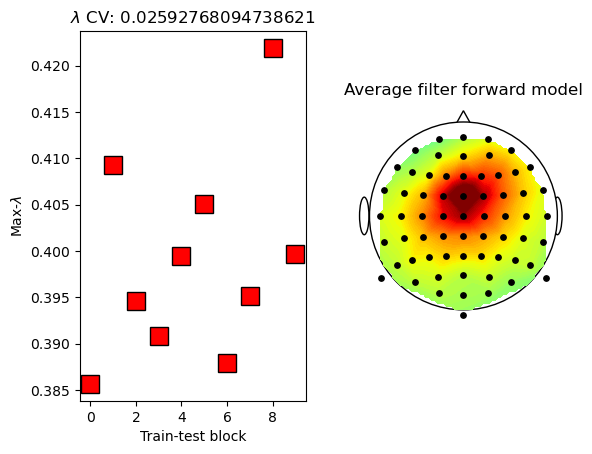

(4096,) (4096,)


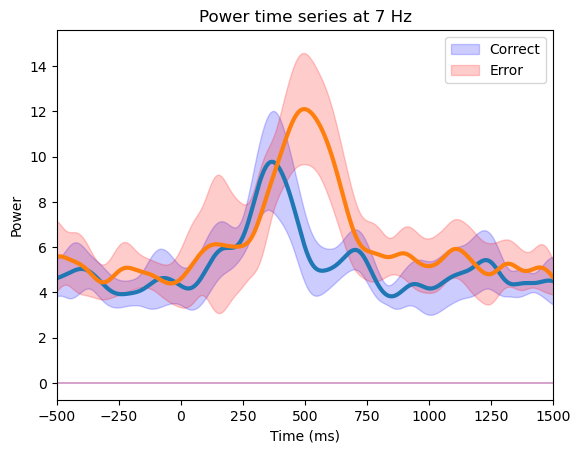

In [33]:
## show results

# Note: A measure of "goodness" is the coefficient of variation (CV).
#       CV is std/mean. Small values are good, large values indicate large
#       uncertainty or lack of precision.

_,axs = plt.subplots(1,2)
axs[0].plot(maxevals,'ks',markersize=13,markerfacecolor='r')
axs[0].set_title(f'$\lambda$ CV: {np.std(maxevals)/np.mean(maxevals)}')
axs[0].set_xlabel('Train-test block')
axs[0].set_ylabel('Max-$\lambda$')

# average of all component maps
topoplotIndie(np.mean(maps,axis=0),EEG['chanlocs'],'Average filter forward model',axs[1])
plt.show()


# power time courses (first compute standard error and average across blocks).
ste_pow = np.std(powts,axis=0) / np.sqrt(numblocks-1)
ave_pow = np.mean(powts,axis=0)


# show in patches
xx = np.hstack((EEG['times'],EEG['times'][::-1]))
yy = np.hstack( (ave_pow[0,:]+2*ste_pow[0,:],ave_pow[0,::-1]-2*ste_pow[0,::-1]) )

print(xx.shape,yy.shape)

plt.fill_between(xx,yy,alpha=.2,color='b')

yy = np.hstack( (ave_pow[1,:]+2*ste_pow[1,:],ave_pow[1,::-1]-2*ste_pow[1,::-1]) )
plt.fill_between(xx,yy,alpha=.2,color='r')

# and average on top
plt.plot(EEG['times'],np.mean(powts,axis=0).T,linewidth=3)
plt.xlim([-500,1500])
plt.legend(['Correct','Error'])
plt.title(f'Power time series at {filterCent} Hz')
plt.xlabel('Time (ms)')
plt.ylabel('Power')
plt.show()